In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import torch
from tqdm import tqdm
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from trainer import Trainer
from utils import Logger
import importlib
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py

Modules loaded


<module 'data_loader.data_loaders' from '/home/awoloshuk/KPMP/MNIST/data_loader/data_loaders.py'>

In [44]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics

    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    #print(os.path.isfile(data_loader.dataset))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    print(torch.cuda.get_device_name(0))

    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for 'nll_loss'
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    trainer = Trainer(model, loss, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)

    trainer.train()



In [45]:
config_file = 'config2.json'
# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

In [46]:
#Train the network
main(config, None)

look something is here
MnistModel(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
Trainable parameters: 21840
Tesla K80


Train Epoch: 1 [0/54000 (0%)] Loss: 2.324240
Train Epoch: 1 [1408/54000 (3%)] Loss: 2.238546
Train Epoch: 1 [2816/54000 (5%)] Loss: 2.074976
Train Epoch: 1 [4224/54000 (8%)] Loss: 1.677706
Train Epoch: 1 [5632/54000 (10%)] Loss: 1.464669
Train Epoch: 1 [7040/54000 (13%)] Loss: 1.123284
Train Epoch: 1 [8448/54000 (16%)] Loss: 1.068896
Train Epoch: 1 [9856/54000 (18%)] Loss: 0.945049
Train Epoch: 1 [11264/54000 (21%)] Loss: 0.968626
Train Epoch: 1 [12672/54000 (23%)] Loss: 0.869770
Train Epoch: 1 [14080/54000 (26%)] Loss: 0.761970
Train Epoch: 1 [15488/54000 (29%)] Loss: 0.688816
Train Epoch: 1 [16896/54000 (31%)] Loss: 0.617276
Train Epoch: 1 [18304/54000 (34%)] Loss: 0.709790
Train Epoch: 1 [19712/54000 (36%)] Loss: 0.627121
Train Epoch: 1 [21120/54000 (39%)] Loss: 0.481531


KeyboardInterrupt: 

In [124]:
def main2(config, resume):
    # setup data_loader instances
    data_loader = getattr(module_data, config['data_loader']['type'])(
        config['data_loader']['args']['data_dir'],
        batch_size=512,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=2
    )
    
    # build model architecture
    model = get_instance(module_arch, 'arch', config)
    print(model)
    print(torch.cuda.get_device_name(0))


    
    # get function handles of loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    # load state dict
    checkpoint = torch.load(resume)
    state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict) 
    
    # prepare model for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() #tells model to ignore dropout and batch normalization
    
    total_loss = 0.0
    total_metrics = torch.zeros(len(metric_fns))
    
    with torch.no_grad(): #speed up calculations, unable to perform back propogation
        for i, (data, target) in enumerate(tqdm(data_loader)): #tqdm is a progress bar
            data, target = data.to(device), target.to(device)
            output = model(data)
            #
            # save sample images, or do something with output here
            #
            
            
            if i < 5:
                fig = plt.figure()
                output_cpu = output.to(torch.device("cpu"))
                plt.title("Prediction = " + str(np.argmax(output_cpu[1], axis=0)))
                data_cpu = data.to(torch.device("cpu"))
                plt.imshow(data_cpu[1].view([28,28]))
                
            # computing loss, metrics on test set
            loss = loss_fn(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size
        
        plt.show()
                      
    n_samples = len(data_loader.sampler)
    print("num samples = " + str(n_samples))
    log = {'loss': total_loss / n_samples}
    log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
    print(log)
    print("My_metric is accuracy, my_metric2 is top-3 accuracy")

In [125]:
resume = "saved/Mnist_LeNet/0414_203632/model_best.pth"

print(os.path.isdir("saved/Mnist_LeNet/0414_203632"))
print(os.path.exists(resume))

#config = torch.load("saved/Mnist_LeNet/0414_203632/config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True


  0%|          | 0/20 [00:00<?, ?it/s]

MnistModel(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
Trainable parameters: 21840
Tesla K80


100%|██████████| 20/20 [00:01<00:00, 18.09it/s]


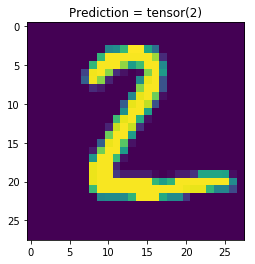

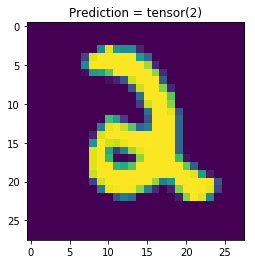

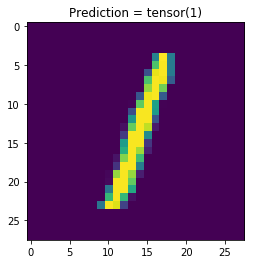

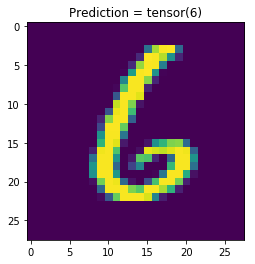

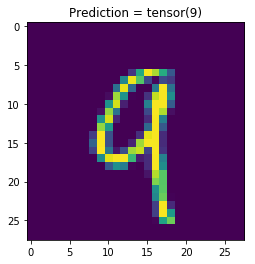

num samples = 10000
{'my_metric': 0.9867, 'loss': 0.04054535250663757, 'my_metric2': 0.9995}
My_metric is accuracy, my_metric2 is top-3 accuracy


In [126]:
#Test
main2(config, resume)